In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import transforms
import os
import torch.nn.functional as F

from config import train_config
from model import SRGAN_GEN, SRGAN_DISC
from loss import PerceptualLoss, DiscriminatorLoss
from data import UcsrTrainValidDataset
from utils import psnr_srgan, ssim_srgan
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = SRGAN_GEN()

# 저장된 가중치 로드
model.load_state_dict(torch.load("/home/lab/work/SRGAN/SRResnet_parameters/srresnet_epoch0_psnr27.70428617718877.pt", map_location=torch.device('cpu')))

/tmp/ipykernel_324571/2618368590.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/lab/work/SRGAN/SRResnet_parameters/srresnet_epoc

<All keys matched successfully>

In [14]:
lr_image = Image.open('/home/lab/Datasets/SRGAN_data/Train_patches2/patch_1.png').convert("RGB")
lr_tensor = torch.as_tensor(np.array(lr_image) / 255.0, dtype=torch.float32).permute(2, 0, 1) #### 억까 심하네.. transforms.ToTensor()대신 쓰기

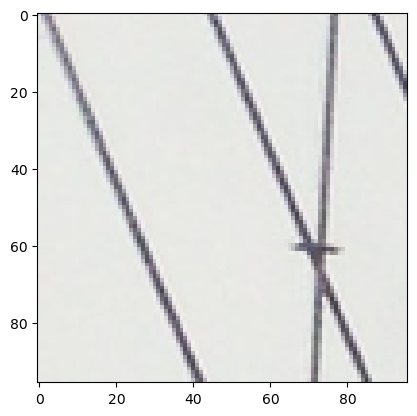

In [15]:
plt.imshow(lr_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())

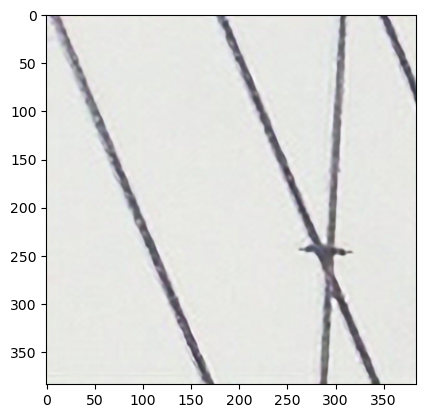

In [16]:
sr = model(lr_tensor.unsqueeze(0))
plt.imshow(sr.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())

In [18]:
psnr_srgan(lr_tensor, sr.squeeze(0))

ValueError: operands could not be broadcast together with shapes (3,96,96) (3,384,384) 

In [ ]:
valid_path = train_config['valid_data_path']
valid_images_path_list = [os.path.join(valid_path, f) for f in os.listdir(valid_path)]

avg_val_psnr = 0
epoch_val_psnr = 0
model = model.to(train_config['device'])
model.eval()

for f in valid_images_path_list:
    hr_image = Image.open(f).convert("RGB")
    transform_to_lr = transforms.Compose([
            transforms.Resize(
                (hr_image.size[1] // train_config['downsampling_factor'], 
                hr_image.size[1] // train_config['downsampling_factor']), 
                interpolation=transforms.InterpolationMode.BICUBIC
                )  
        ])
    lr_image = transform_to_lr(hr_image)
    
    hr_tensor = torch.as_tensor(np.array(hr_image) / 255.0, dtype=torch.float32).permute(2, 0, 1) #### 억까 심하네.. transforms.ToTensor()대신 쓰기
    lr_tensor = torch.as_tensor(np.array(lr_image) / 255.0, dtype=torch.float32).permute(2, 0, 1) 
    hr_tensor = hr_tensor.to(train_config['device'])
    lr_tensor = lr_tensor.to(train_config['device'])
    
    sr_valid = model(lr_tensor.unsqueeze(0)).to(train_config['device'])
    sr_valid = sr_valid.squeeze(0)
    epoch_val_psnr += psnr_srgan(sr_valid, hr_tensor)

ValueError: operands could not be broadcast together with shapes (3,896,896) (3,512,512) 

In [9]:
input, target = valid_data[1]
print(input.shape, target.shape)

torch.Size([3, 120, 125]) torch.Size([3, 480, 500])


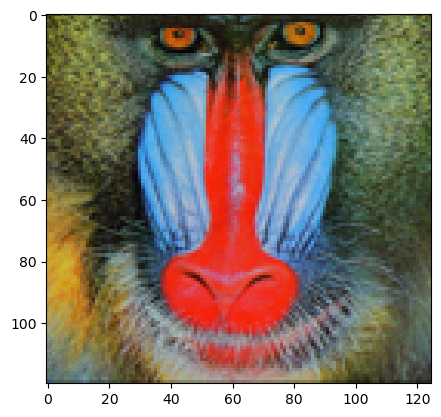

In [7]:
plt.imshow(input.permute(1, 2, 0).numpy())

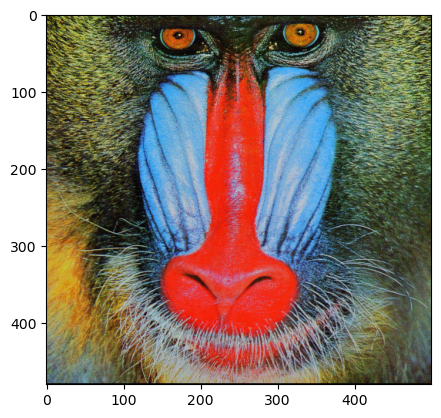

In [8]:
plt.imshow(target.permute(1, 2, 0).numpy())